<div align="center"><h1> Projet Data Science </h1></div>
<div align="center"><h2> Classification d'assertions selon leur valeurs de véracité ( automatic fact-checking ) </h2></div>

<div class="alert alert-block alert-info" align="center">
    <h1>
        Executing the basic
    </h1>
</div>

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import warnings
import nltk
import pickle
import unicodedata
import inflect
import re
import time
import contractions

from enum import Enum
from functools import reduce
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

warnings.filterwarnings("ignore", category = FutureWarning)

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
    
try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger')

# Reding data
def read_data(*args, **kwargs):
    data = kwargs.get("data", 'test')
    number = kwargs.get("number", 1000)
    labels = ["ID", "Text", "Date", "TruthRating", "RatingName", "Author", "Headline", 
              "NamedEntitiesClaim", "NamedEntitiesArticle", "Keywords", "Source", "SourceURL", "Link", "Language"]
    
    if(data not in ['all', 'polsno', 'test']):
        print('Please selecte somthing in [\'all\', \'polsno\', \'test\']')
    else:
        test = pd.read_csv('datasets/test.csv', sep = ',', names = labels, skiprows = 1)
        pol1 = pd.read_csv('datasets/pol1.csv', sep = ',', names = labels, skiprows = 1)
        pol2 = pd.read_csv('datasets/pol2.csv', sep = ',', names = labels, skiprows = 1)
        sno1 = pd.read_csv('datasets/sno1.csv', sep = ',', names = labels, skiprows = 1)
        sno2 = pd.read_csv('datasets/sno2.csv', sep = ',', names = labels, skiprows = 1)
        reste = pd.read_csv('datasets/reste.csv', sep = ',', names = labels, skiprows = 1)

        pol = pol1.append(pol2, sort = False).reset_index(drop = True)
        sno = sno1.append(sno2, sort = False).reset_index(drop = True)
        polsno = pol.append(sno, sort = False).reset_index(drop = True)
        everything = polsno.append(reste, sort = False).reset_index(drop = True)
        
        if(data == 'polsno'):
            if(number > polsno.shape[0]):
                print(f'Not enough data !\nReading only {polsno.shape[0]} claims')
                number = polsno.shape[0]
            print(f'Reading successfully {number} claims')
            df_func = polsno.sample(n = number).reset_index(drop = True)
        if(data == 'all'):
            if(number > everything.shape[0]):
                print(f'Not enough data !\nReading only {everything.shape[0]} claims')
                number = everything.shape[0]
            print(f'Reading successfully {number} claims')
            df_func = everything.sample(n = number).reset_index(drop = True)
        if(data == 'test'):
            if(number > test.shape[0]):
                print(f'Not enough data !\nReading only {test.shape[0]} claims')
                number = test.shape[0]
            print(f'Reading successfully {number} claims')
            df_func = test.sample(n = number).reset_index(drop = True)
        
        for column in df_func.columns:
            if(column == 'RatingName'):
                df_func[column].replace(to_replace = True, value = 'TRUE', inplace = True)
                df_func[column].replace(to_replace = False, value = 'FALSE', inplace = True)
        
        df_func.to_csv('datasets/generated.csv', sep = ',', index = False)
        print(f'\nFile \'generated.csv\' created !\nYou can found this data frame in the following path datasets/generated.csv')

        return df_func

<div class="alert alert-block alert-info" align="center">
    <h1>
        Generating & saving data
    </h1>
</div>

<h2>read_data(data='test', number = '1000')</h2>
<ul>
    <li><b>data</b></li>
	<ul>
		<li>'all' for all website</li>
		<li>'polsno' for politifact's and snopes' claims </li>
		<li>'test' for csv test (all sites) with 10000 claims max</li>
	</ul>
        <li><b>number</b></li>
	<ul>
		<li>number of claims to generate</li>
	</ul>
</ul>

In [2]:
df = read_data(data = 'test', number = 1000)

Reading successfully 1000 claims

File 'generated.csv' created !
You can found this data frame in the following path datasets/generated.csv


<div class="alert alert-block alert-info" align="center">
    <h1>
        Printing informations
    </h1>
</div>

## Shape

In [3]:
print(f'Shape :\n{df.shape}')

Shape :
(1000, 14)


## Informations

In [4]:
print(f'Informations :')
df.info()

Informations :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
ID                      1000 non-null object
Text                    1000 non-null object
Date                    1000 non-null object
TruthRating             1000 non-null int64
RatingName              1000 non-null object
Author                  1000 non-null object
Headline                990 non-null object
NamedEntitiesClaim      987 non-null object
NamedEntitiesArticle    628 non-null object
Keywords                867 non-null object
Source                  1000 non-null object
SourceURL               1000 non-null object
Link                    1000 non-null object
Language                1000 non-null object
dtypes: int64(1), object(13)
memory usage: 109.5+ KB


## Description

In [5]:
print(f'Description :')
display(df.describe())

Description :


,TruthRating
count,1000.000000
mean,1.226000
std,1.249995
min,-1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,3.000000


## Printing some lines

In [6]:
print(f'Printing some lines :')
display(df.head())

Printing some lines :


,ID,Text,Date,TruthRating,RatingName,Author,Headline,NamedEntitiesClaim,NamedEntitiesArticle,Keywords,Source,SourceURL,Link,Language
0,http://data.gesis.org/claimskg/claim_review/ca...,Says Marco Rubio 'skipped 18 defense votes inc...,2016-03-06,2,MIXTURE,Keep the Promise 1 PAC,Pro-Ted Cruz PAC says Marco Rubio skipped 18 d...,"American Enterprise Institute,Ash Carter,Barac...","ISIS,Kurds,Marco Rubio","Military,Voting Record",politifact,http://www.politifact.com,http://www.politifact.com/florida/statements/2...,English
1,http://data.gesis.org/claimskg/claim_review/88...,Does The US Have Trade Deficits With ‘Almost A...,Unknown,-1,OTHER,Unknown,Does The US Have Trade Deficits With ‘Almost A...,"Alan Deardorff,Brazil,Bureau of Economic Analy...",NaN,NaN,checkyourfact,http://checkyourfact.com,https://checkyourfact.com/2018/03/21/fact-chec...,English
2,http://data.gesis.org/claimskg/claim_review/0f...,"'There is great disparity, tremendous disparit...",2016-02-09,2,MIXTURE,Janet Adkins,Traditional schools get much more capital fund...,"Education, Florida,Erik Fresen,Florida Departm...",NaN,"Education,State Budget,Taxes",politifact,http://www.politifact.com,http://www.politifact.com/florida/statements/2...,English
3,http://data.gesis.org/claimskg/claim_review/cc...,Target.com or Target blocked Israel from acces...,Unknown,2,MIXTURE,Unknown,Target Blocks Israel from E-Commerce Access?,"Chabin,Forever 21,Israel,Jerusalem,Old Navy,Ta...","Israel,Target.com","israel, onlysimchas, target, target.com",snopes,http://www.snopes.com,https://www.snopes.com/fact-check/target-block...,English
4,http://data.gesis.org/claimskg/claim_review/0a...,"Each refugee in Canada receives $3,874 every m...",Unknown,2,MIXTURE,Unknown,"Do ‘Illegal’ Refugees Receive $3,874 Per Month...","British Columbia,Canadian Council for Refugees...",NaN,NaN,snopes,http://www.snopes.com,https://www.snopes.com/fact-check/monthly-refu...,English


## Affichage d'informations sur toutes les colonnes

In [7]:
for column in df.columns:
      print(f'Nombre de valeurs nulles pour {column} :\n{df[column].isnull().value_counts()}\n')

Nombre de valeurs nulles pour ID :
False    1000
Name: ID, dtype: int64

Nombre de valeurs nulles pour Text :
False    1000
Name: Text, dtype: int64

Nombre de valeurs nulles pour Date :
False    1000
Name: Date, dtype: int64

Nombre de valeurs nulles pour TruthRating :
False    1000
Name: TruthRating, dtype: int64

Nombre de valeurs nulles pour RatingName :
False    1000
Name: RatingName, dtype: int64

Nombre de valeurs nulles pour Author :
False    1000
Name: Author, dtype: int64

Nombre de valeurs nulles pour Headline :
False    990
True      10
Name: Headline, dtype: int64

Nombre de valeurs nulles pour NamedEntitiesClaim :
False    987
True      13
Name: NamedEntitiesClaim, dtype: int64

Nombre de valeurs nulles pour NamedEntitiesArticle :
False    628
True     372
Name: NamedEntitiesArticle, dtype: int64

Nombre de valeurs nulles pour Keywords :
False    867
True     133
Name: Keywords, dtype: int64

Nombre de valeurs nulles pour Source :
False    1000
Name: Source, dtype: int64


## Affichage des colonnes vides

In [8]:
array = []
for column in df.columns:
    value = False
    value = df[column].isnull().any()
    if value:
        array.append(column)
print(f'Nombre de colonnes vides : {len(array)}\nLes colonnes vide sont :\n{array}')

Nombre de colonnes vides : 4
Les colonnes vide sont :
['Headline', 'NamedEntitiesClaim', 'NamedEntitiesArticle', 'Keywords']


## Description de toutes les colonnes

In [9]:
for column in df.columns:
    display(df[column].describe())

count                                                  1000
unique                                                 1000
top       http://data.gesis.org/claimskg/claim_review/23...
freq                                                      1
Name: ID, dtype: object

count                                                  1000
unique                                                 1000
top       Confederate Soldiers Are Considered U.S. Veter...
freq                                                      1
Name: Text, dtype: object

count        1000
unique        511
top       Unknown
freq          460
Name: Date, dtype: object

count    1000.000000
mean        1.226000
std         1.249995
min        -1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         3.000000
Name: TruthRating, dtype: float64

count      1000
unique        4
top       FALSE
freq        357
Name: RatingName, dtype: object

count        1000
unique        347
top       Unknown
freq          461
Name: Author, dtype: object

count                                                   990
unique                                                  990
top       This video has circulated online since 2017 in...
freq                                                      1
Name: Headline, dtype: object

count                                                   987
unique                                                  987
top       Barack Obama,Bob Goodlatte,Daily Currant,Fast ...
freq                                                      1
Name: NamedEntitiesClaim, dtype: object

count              628
unique             562
top       Donald Trump
freq                12
Name: NamedEntitiesArticle, dtype: object

count             867
unique            605
top       ASP Article
freq               40
Name: Keywords, dtype: object

count           1000
unique             9
top       politifact
freq             512
Name: Source, dtype: object

count                          1000
unique                            9
top       http://www.politifact.com
freq                            512
Name: SourceURL, dtype: object

count                                                  1000
unique                                                 1000
top       http://www.politifact.com/georgia/statements/2...
freq                                                      1
Name: Link, dtype: object

count        1000
unique          1
top       English
freq         1000
Name: Language, dtype: object

## Get a series of unique values in each column of the dataframe

In [10]:
for column in df.columns:
    uniqueValues = df[column].unique()
    print(f'Number of unique elements in column {column} : {len(uniqueValues)}, values & type :\n{uniqueValues}\n')

Number of unique elements in column ID : 1000, values & type :
['http://data.gesis.org/claimskg/claim_review/caa5353d-fba9-5249-a41b-cf4c9e89f8fb'
 'http://data.gesis.org/claimskg/claim_review/8867670e-e6a5-553d-9d9c-64e82d29a20b'
 'http://data.gesis.org/claimskg/claim_review/0f5d944e-afd0-5938-bdf5-a34a586f0067'
 'http://data.gesis.org/claimskg/claim_review/cc4c98b9-d20f-538b-b5aa-bcb64ccb7813'
 'http://data.gesis.org/claimskg/claim_review/0a1138ba-47da-581d-bd28-6d3596cb892d'
 'http://data.gesis.org/claimskg/claim_review/fbdbf64d-1cb1-57b1-8a38-7358d5d62941'
 'http://data.gesis.org/claimskg/claim_review/f7552e28-637b-5e8e-8efd-2605655ba3bb'
 'http://data.gesis.org/claimskg/claim_review/6860c5c2-cdb1-568d-aee1-f08567e06f34'
 'http://data.gesis.org/claimskg/claim_review/1c2a5334-5b94-5122-bb26-12a61eebee4f'
 'http://data.gesis.org/claimskg/claim_review/772730e7-f326-5911-aeea-f1cea8ece7a3'
 'http://data.gesis.org/claimskg/claim_review/a12b7af0-a9d3-5a67-a934-14e3dc7a2827'
 'http://data

## Affichage du nombre des différents TruthRating

In [11]:
print(f'La colonne TruthRating contient :')
print(f'{df[df["TruthRating"]==-1]["ID"].count()} Other')
print(f'{df[df["TruthRating"]==1]["ID"].count()} False')
print(f'{df[df["TruthRating"]==2]["ID"].count()} Mixture')
print(f'{df[df["TruthRating"]==3]["ID"].count()} True')

La colonne TruthRating contient :
185 Other
357 False
320 Mixture
138 True


<div class="alert alert-block alert-info" align="center">
    <h1>
        Visualization
    </h1>
</div>

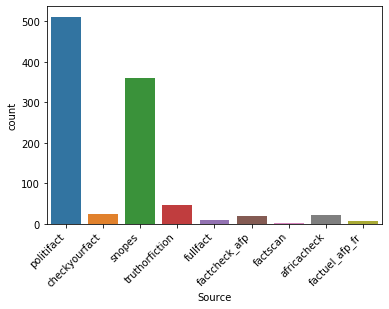

In [12]:
chart = sns.countplot(x = 'Source', data = df)
plt.setp(chart.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
plt.show()

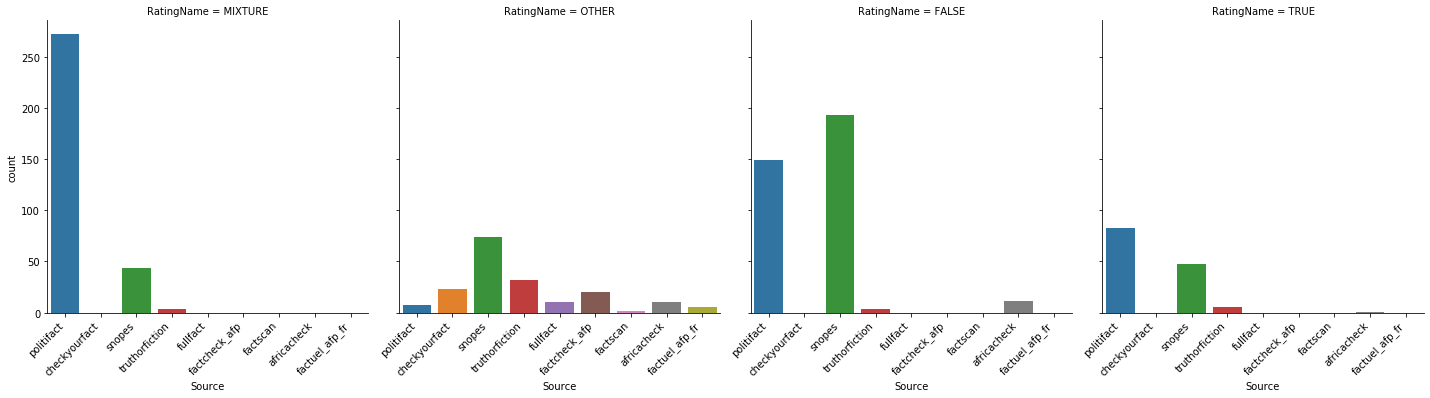

In [13]:
chart = sns.catplot(x = 'Source', col = 'RatingName', kind = 'count', data = df)
for ax in chart.axes.ravel():
    plt.setp(ax.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
plt.show()

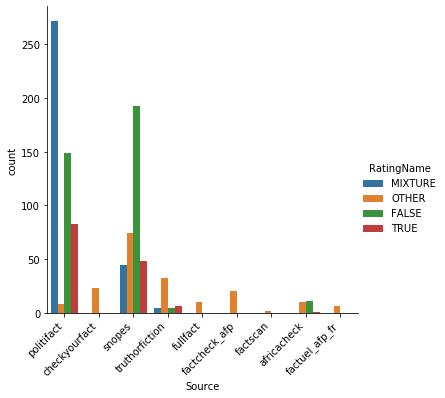

In [14]:
chart = sns.catplot('Source', data = df, hue = 'RatingName', kind = 'count')
for ax in chart.axes.ravel():
    plt.setp(ax.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
plt.show()

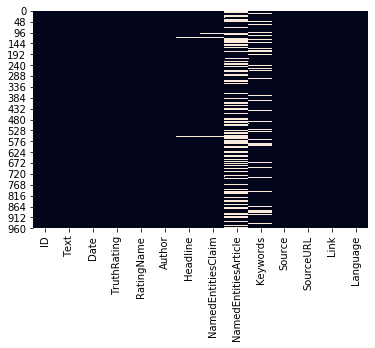

In [15]:
sns.heatmap(df.isnull(), cbar = False)
plt.show()